### Finding 2: Verkaufzahlen von Rossmann in Ferienzeiten und Feiertagen
Wir gehen davon aus das sich die Verkaufszahlen von Rossmann in den Ferienzeiten und Feiertagen verändern, 
dies ist in der folgenden Analyse sehr gut zu erkennen.

Zunächst werden die Daten wie gewohnt geladen und gecleant

In [72]:
import pandas as pd

In [73]:
store_df = pd.read_csv('store.csv')
df = pd.read_csv('train.csv')

/var/folders/r6/ltx5hdzx6lxg2rtm5cn9qqf80000gn/T/ipykernel_57697/305629052.py:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('train.csv')


In [74]:
merged_df = pd.merge(df, store_df, on='Store', how='left')

In [75]:
merged_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [77]:
# Daten aus Date extrahieren (Jahr, Monat, Tag)
merged_df["Year"] = merged_df["Date"].str.slice(0, 4)
merged_df["Month"] = merged_df["Date"].str.slice(5, 7)
merged_df["Day"] = merged_df["Date"].str.slice(8, 10)
merged_df["Year"] = merged_df["Year"].astype("Int32")
merged_df["Month"] = merged_df["Month"].astype("Int32")
merged_df["Day"] = merged_df["Day"].astype("Int32")
merged_df.drop(columns=["Date"], inplace=True)

In [78]:
# Null Werte behandeln
merged_df["CompetitionDistance"].fillna(merged_df["CompetitionDistance"].mean(),inplace=True)
merged_df.fillna(-1, inplace=True)

In [79]:
from sklearn.preprocessing import LabelEncoder

# Fehlschlag: Ohne die folgenden Zeilen schlägt das kodieren fehl, weil die Datentypen innerhalb einer oder mehrerer Spalten uneinheitlich sind
merged_df["StateHoliday"] = merged_df["StateHoliday"].astype(str)
merged_df["StoreType"] = merged_df["StoreType"].astype(str)
merged_df["Assortment"] = merged_df["Assortment"].astype(str)
merged_df["PromoInterval"] = merged_df["PromoInterval"].astype(str)


columns_to_encode = ["StateHoliday", "StoreType", "Assortment", "PromoInterval"]

label_encoder = LabelEncoder()

for column in columns_to_encode:   
    merged_df[column] = label_encoder.fit_transform(merged_df[column])
merged_df.head()


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day
0,1,5,5263,555,1,1,0,1,2,0,1270.0,9.0,2008.0,0,-1.0,-1.0,0,2015,7,31
1,2,5,6064,625,1,1,0,1,0,0,570.0,11.0,2007.0,1,13.0,2010.0,2,2015,7,31
2,3,5,8314,821,1,1,0,1,0,0,14130.0,12.0,2006.0,1,14.0,2011.0,2,2015,7,31
3,4,5,13995,1498,1,1,0,1,2,2,620.0,9.0,2009.0,0,-1.0,-1.0,0,2015,7,31
4,5,5,4822,559,1,1,0,1,0,0,29910.0,4.0,2015.0,0,-1.0,-1.0,0,2015,7,31


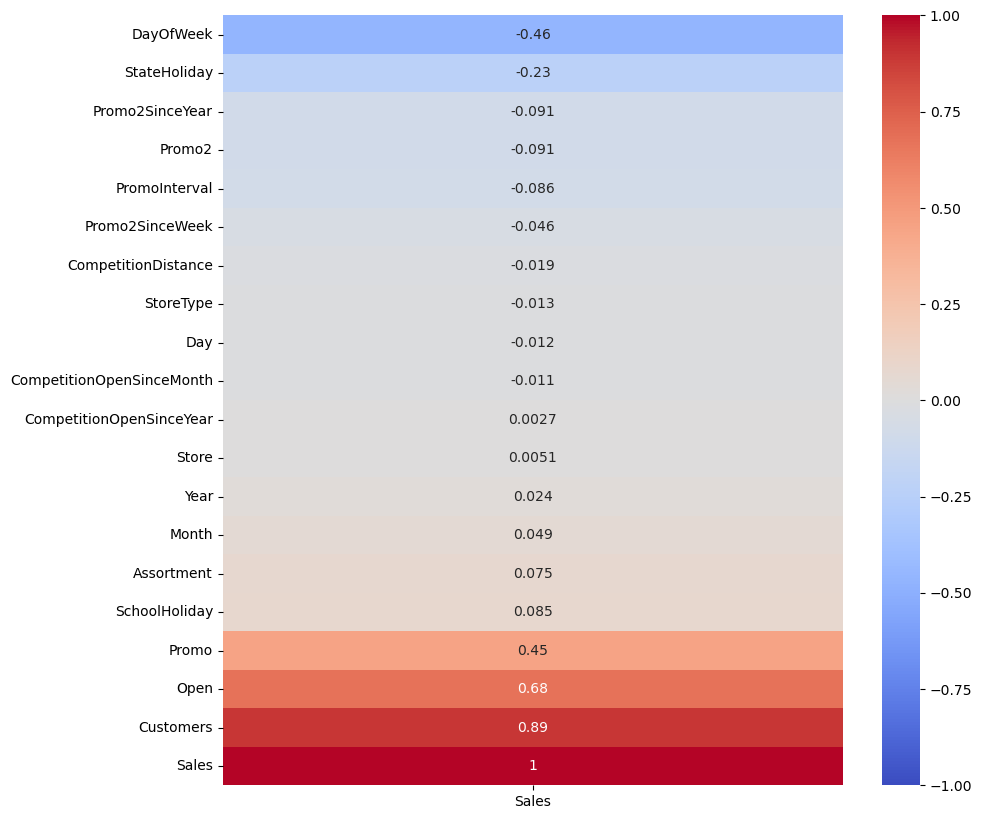

In [82]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
sns.heatmap(merged_df.corr()[['Sales']].sort_values('Sales'), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.show()

### CompetitionOpenSinceMonth und CompetitionOpenSinceYear hatten beide sehr viele fehlende Werte und scheinen eher irrelevant, weshalb wir sie rauswerfen

In [1]:
# merged_df.drop(columns=["CompetitionOpenSinceMonth","CompetitionOpenSinceYear"], inplace=True)

### Das auslassen der Spalten wurde später verworfen, weil die feature importance vom Random Forest darauf hindeutet, dass diese Features doch relevant sind

# Ab hier beginnt das Finding 


Zunächst lassen wir uns wieder ein Date ausgeben


In [91]:
import pandas as pd
date_strings = merged_df['Year'].astype(str) + '-' + merged_df['Month'].astype(str) + '-' + merged_df['Day'].astype(str)

merged_df['Date'] = pd.to_datetime(date_strings, format='%Y-%m-%d')

merged_df

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,Date
0,1,5,5263,555,1,1,0,1,2,0,1270.0,0,-1.0,-1.0,0,2015,7,31,2015-07-31
1,2,5,6064,625,1,1,0,1,0,0,570.0,1,13.0,2010.0,2,2015,7,31,2015-07-31
2,3,5,8314,821,1,1,0,1,0,0,14130.0,1,14.0,2011.0,2,2015,7,31,2015-07-31
3,4,5,13995,1498,1,1,0,1,2,2,620.0,0,-1.0,-1.0,0,2015,7,31,2015-07-31
4,5,5,4822,559,1,1,0,1,0,0,29910.0,0,-1.0,-1.0,0,2015,7,31,2015-07-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,0,0,0,0,1,1,0,0,1900.0,1,31.0,2013.0,2,2013,1,1,2013-01-01
1017205,1112,2,0,0,0,0,1,1,2,2,1880.0,0,-1.0,-1.0,0,2013,1,1,2013-01-01
1017206,1113,2,0,0,0,0,1,1,0,2,9260.0,0,-1.0,-1.0,0,2013,1,1,2013-01-01
1017207,1114,2,0,0,0,0,1,1,0,2,870.0,0,-1.0,-1.0,0,2013,1,1,2013-01-01


## Auswirkung von Schulferien auf den Umsatz

Die Visualisierung zeigt den durchschnittlichen Umsatz während Schulferien im Vergleich zu Nicht-Schulferien. Die Balken repräsentieren die beiden Kategorien, wobei der Umsatz während der Schulferien etwas höher zu sein scheint. Die genauen Werte über den Balken zeigen die Unterschiede zwischen den beiden Kategorien.


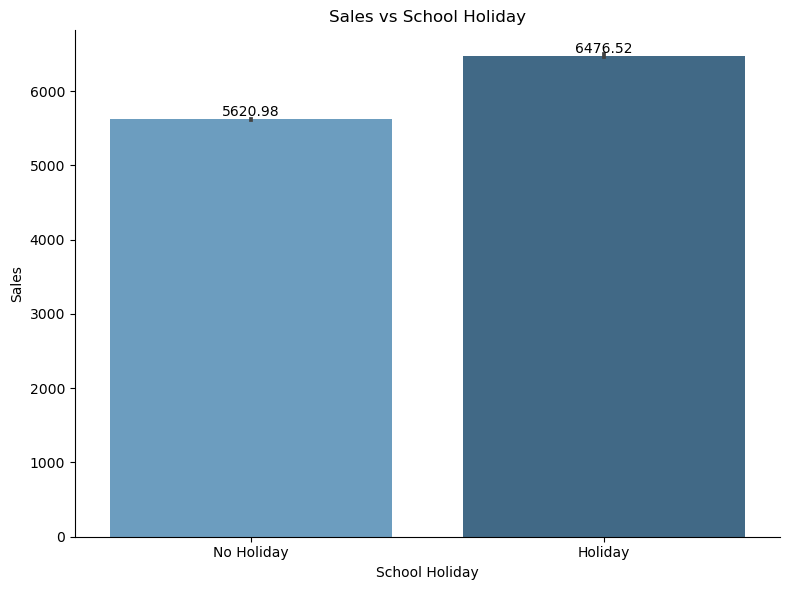

In [85]:

# Ich möchte sehen ob die Sales steigen wenn Schulferien sind 
import matplotlib.pyplot as plt
import seaborn as sns

#Namen verändern
holiday_labels = {0: "No Holiday", 1: "Holiday"}

plt.figure(figsize=(8, 6))  
sns.barplot(x="SchoolHoliday", y="Sales", data=merged_df, palette="Blues_d")
sns.despine()
plt.xlabel("School Holiday")
plt.ylabel("Sales")
plt.title("Sales vs School Holiday")
plt.xticks(ticks=[0, 1], labels=["No Holiday", "Holiday"])

#genaue Werte anzeigen
ax = plt.gca()  
for p in ax.patches:
   ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
              ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
              textcoords='offset points')
    
plt.tight_layout()  

plt.show()

## Durchschnittliche Verkäufe pro Monat

Die Visualisierung zeigt den durchschnittlichen Umsatz pro Monat über das Jahr hinweg.

- **Visualisierung**:
  - Die blaue Linie repräsentiert die durchschnittlichen Verkäufe von Januar bis Oktober.
  - Die rote Linie zeigt die Verkäufe von November bis Dezember.
  - Eine gestrichelte grüne Linie kennzeichnet den durchschnittlichen Jahresumsatz.

- **Ergebnisse**:
  - Die Visualisierung zeigt, wie sich die durchschnittlichen Verkäufe im Laufe des Jahres ändern.
  - Es gibt einen deutlichen Anstieg der Verkäufe gegen Ende des Jahres, insbesondere im Dezember.

- **Schlussfolgerung**:
  - Die Daten legen nahe, dass die Verkäufe gegen Ende des Jahres tendenziell höher sind.
  - Dies könnte auf saisonale Trends oder Feiertage wie Weihnachten und Neujahr zurückzuführen sein, insbesondere auf den Weihnachtsmarkt.







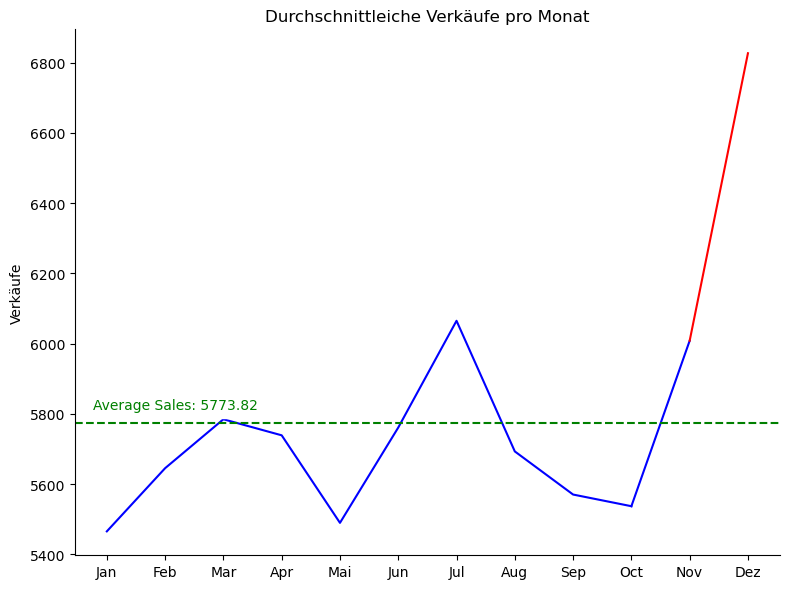

In [86]:
import matplotlib.pyplot as plt

# Plot the average sales per month
plt.figure(figsize=(8, 6))
sales_per_month = merged_df.groupby("Month")["Sales"].mean()

# Plot from January to October
plt.plot(sales_per_month.index[:10], sales_per_month.values[:10], color='blue')

# Plot November (painted blue)
plt.plot(sales_per_month.index[9:11], sales_per_month.values[9:11], color='blue')

# Plot December
plt.plot(sales_per_month.index[11:], sales_per_month.values[11:], color='red')

# Plot November to December (in red)
plt.plot(sales_per_month.index[10:], sales_per_month.values[10:], color='red')

# Plot horizontal line for average sales over the year
average_sales_over_year = merged_df['Sales'].mean()
plt.axhline(y=average_sales_over_year, color='green', linestyle='--')
plt.text(3.6, average_sales_over_year + 50, f'Average Sales: {average_sales_over_year:.2f}', va='center', ha='right', backgroundcolor='w',color='green')

plt.title("Durchschnittleiche Verkäufe pro Monat")
plt.ylabel("Verkäufe") 
plt.xticks(ticks=range(1, 13), labels=["Jan", "Feb", "Mar", "Apr", "Mai", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dez"])
plt.tight_layout()
sns.despine()
plt.show()


Hier wird gezeigt wie die durchschnittlichen Sales von Januar bis Oktober sind. Die Weihnachtszeit wird rot gekennzeichnet

In [87]:
#print out the average sales per month from january to october and take the mean of it
average_sales_per_month = sales_per_month[:10].mean()
average_sales_per_month

5674.991452997617

Hier wird gezeigt wie die durchschnittlichen Sales von November bis Dezember sind

In [88]:
# Print out the average sales per month from november to december and take the mean of it
average_sales_per_month_nov_dec = sales_per_month[10:].mean()
average_sales_per_month_nov_dec

6417.3615990034095

Hier wird der Anstieg in % berechnet 

In [89]:
#whats the percentage increase in sales from january to october to november to december and round 2 decimal places
percentage_increase = ((average_sales_per_month_nov_dec - average_sales_per_month) / average_sales_per_month) * 100
percentage_increase_rounded = round(percentage_increase, 2)
print("Die Sales in der Weihnachtszeit steigen um: {:.2f}%".format(percentage_increase_rounded))


Die Sales in der Weihnachtszeit steigen um: 13.08%


## Durchschnittliche Verkaufszahlen vor und nach Weihnachten und Ostern

Dieser Code berechnet die durchschnittlichen Verkaufszahlen für eine Woche vor und nach Weihnachten sowie für eine Woche vor und nach Ostern. 




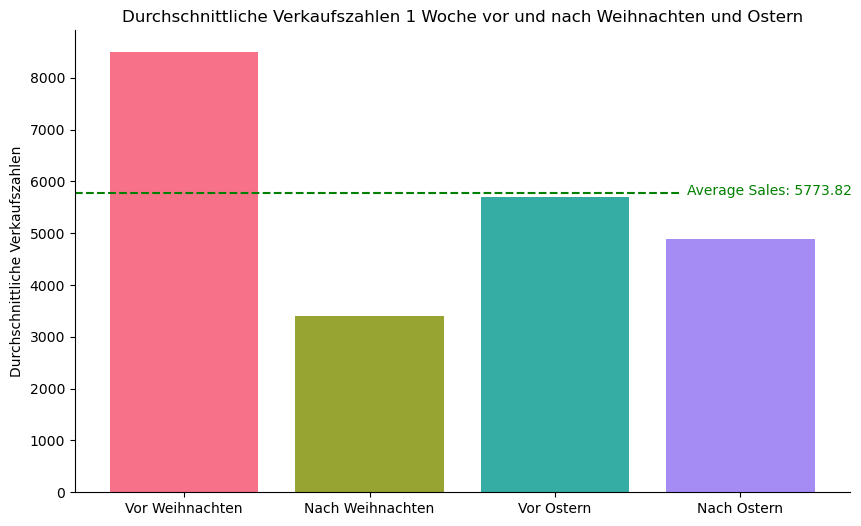

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Stellen Sie sicher, dass die Spalte 'Sales' numerische Werte enthält
merged_df['Sales'] = pd.to_numeric(merged_df['Sales'], errors='coerce')

# Definieren Sie den Zeitraum für Weihnachten und Ostern (eine Woche vor und nach)
christmas_start = pd.to_datetime('2013-12-18')
christmas_end = pd.to_datetime('2014-01-01')  # Eine Woche nach Weihnachten
easter_start = pd.to_datetime('2013-03-24')
easter_end = pd.to_datetime('2013-04-08')  # Eine Woche nach Ostern

# Filtern Sie die Daten für Weihnachten und Ostern
christmas_data = merged_df[(merged_df['Date'] >= christmas_start) & (merged_df['Date'] <= christmas_end)]
easter_data = merged_df[(merged_df['Date'] >= easter_start) & (merged_df['Date'] <= easter_end)]

# Berechnen Sie den Durchschnitt der Verkaufszahlen für die Wochen vor und nach Weihnachten und Ostern
christmas_mean_sales_before = christmas_data[christmas_data['Date'] < pd.to_datetime('2013-12-25')]['Sales'].mean()
christmas_mean_sales_after = christmas_data[christmas_data['Date'] >= pd.to_datetime('2013-12-25')]['Sales'].mean()
easter_mean_sales_before = easter_data[easter_data['Date'] < pd.to_datetime('2013-04-01')]['Sales'].mean()
easter_mean_sales_after = easter_data[easter_data['Date'] >= pd.to_datetime('2013-04-01')]['Sales'].mean()

# Erstellen Sie das Balkendiagramm
labels = ['Vor Weihnachten', 'Nach Weihnachten', 'Vor Ostern', 'Nach Ostern']
sales = [christmas_mean_sales_before, christmas_mean_sales_after, easter_mean_sales_before, easter_mean_sales_after]


# Verwenden Sie eine Seaborn-Farbpalette
colors = sns.color_palette('husl', n_colors=len(labels))

plt.figure(figsize=(10, 6))

plt.bar(labels, sales, color=colors)

# Plot horizontal line for average sales over the year
average_sales_over_year = merged_df['Sales'].mean()
plt.axhline(y=average_sales_over_year, color='green', linestyle='--')
plt.text(3.6, average_sales_over_year + 50, f'Average Sales: {average_sales_over_year:.2f}', va='center', ha='right', backgroundcolor='w',color='green')

plt.title('Durchschnittliche Verkaufszahlen 1 Woche vor und nach Weihnachten und Ostern')
plt.ylabel('Durchschnittliche Verkaufszahlen')
sns.despine()
plt.show()


## Hier kann man deutlich sehen das die Sales vor Weihnachten weit über dem Durchschnitt sind

## Bestätigung der These

##### Die Verkaufszahlen steigen tatsälich an wenn Ferien oder Feiertage sind, dies ist durch die obiegen Graphen deutlich zu erkennen.